In [4]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS, cluster_optics_dbscan, DBSCAN
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import preprocessing
from sklearn.manifold import TSNE
import matplotlib.cm as cm

In [5]:
priceData = pd.read_csv('all_stocks_5yr.csv')

In [6]:
processed = pd.DataFrame()
for stock in np.unique(priceData["Name"]):
    df = pd.DataFrame()
    df = priceData.loc[priceData['Name'] == stock][['date','close']]
    df = df.transpose()
    df.columns = df.iloc[0]
    df = df.drop(df.index[0])
    df = df.rename(index={'close': stock})
    processed = pd.concat([processed, df])
processed

date,2013-02-08,2013-02-11,2013-02-12,2013-02-13,2013-02-14,2013-02-15,2013-02-19,2013-02-20,2013-02-21,2013-02-22,...,2018-01-25,2018-01-26,2018-01-29,2018-01-30,2018-01-31,2018-02-01,2018-02-02,2018-02-05,2018-02-06,2018-02-07
A,45.08,44.6,44.62,44.75,44.58,42.25,43.01,42.24,41.63,41.8,...,73.86,74.82,74.53,72.99,73.43,72.83,71.25,68.22,68.45,68.06
AAL,14.75,14.46,14.27,14.66,13.99,14.5,14.26,13.33,13.37,13.57,...,53.05,53.07,52.68,52.59,54.32,53.88,52.1,49.76,51.18,51.4
AAP,78.9,78.39,78.6,78.97,78.84,79,80.72,79.5,79.06,79.21,...,120.92,123.64,122.89,119.27,116.99,117.29,113.93,109.86,112.2,109.93
AAPL,67.8542,68.5614,66.8428,66.7156,66.6556,65.7371,65.7128,64.1214,63.7228,64.4014,...,171.11,171.51,167.96,166.97,167.43,167.78,160.5,156.49,163.03,159.54
ABBV,36.25,35.85,35.42,35.27,36.57,37.58,38.19,38.61,38.78,38.46,...,108.3,123.21,122.31,115.88,112.22,116.34,115.17,109.51,111.2,113.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYL,27.09,27.46,27.95,28.26,28.47,28.28,28.76,27.96,27.68,27.79,...,73.24,74.41,73.41,73.07,72.26,74.84,75.66,72.66,71.33,71.79
YUM,65.3,64.55,64.75,64.41,63.89,63.99,65.15,64.56,65.05,65.45,...,85.66,86.2,86.48,84.59,84.59,83.98,82.63,79.8,80.58,80.13
ZBH,75.85,75.65,75.44,76,76.34,75.9,76.11,75.31,73.87,74.14,...,124.74,126.23,127.39,125.94,127.12,128.19,125.79,123.18,122.3,120.78
ZION,24.14,24.21,24.49,24.74,24.63,24.34,24.69,24.14,23.73,24.04,...,53.02,54.02,54.19,53.93,54.03,54.98,54.15,51.65,52.52,54.02


In [7]:
dailyChange = processed.T.pct_change().T #calculate daily percent change
dailyChange = dailyChange.drop(['2013-02-08'], axis = 1) #needed because first column will be null due to percent change
dailyChange = dailyChange.dropna() #drop stocks that do not start at date: 2013-02-08
dailyChange.head()

date,2013-02-11,2013-02-12,2013-02-13,2013-02-14,2013-02-15,2013-02-19,2013-02-20,2013-02-21,2013-02-22,2013-02-25,...,2018-01-25,2018-01-26,2018-01-29,2018-01-30,2018-01-31,2018-02-01,2018-02-02,2018-02-05,2018-02-06,2018-02-07
A,-0.010648,0.000448,0.002913,-0.003799,-0.052266,0.017988,-0.017903,-0.014441,0.004084,-0.012201,...,0.003805,0.012998,-0.003876,-0.020663,0.006028,-0.008171,-0.021694,-0.042526,0.003371,-0.005698
AAL,-0.019661,-0.013140,0.027330,-0.045703,0.036455,-0.016552,-0.065217,0.003001,0.014959,-0.040531,...,-0.031758,0.000377,-0.007349,-0.001708,0.032896,-0.008100,-0.033036,-0.044914,0.028537,0.004299
AAP,-0.006464,0.002679,0.004707,-0.001646,0.002029,0.021772,-0.015114,-0.005535,0.001897,-0.010731,...,-0.000579,0.022494,-0.006066,-0.029457,-0.019116,0.002564,-0.028647,-0.035724,0.021300,-0.020232
AAPL,0.010422,-0.025067,-0.001903,-0.000899,-0.013780,-0.000370,-0.024218,-0.006216,0.010649,-0.017768,...,-0.017851,0.002338,-0.020699,-0.005894,0.002755,0.002090,-0.043390,-0.024984,0.041792,-0.021407
ABBV,-0.011034,-0.011994,-0.004235,0.036859,0.027618,0.016232,0.010998,0.004403,-0.008252,-0.028341,...,0.026443,0.137673,-0.007305,-0.052571,-0.031584,0.036714,-0.010057,-0.049145,0.015432,0.021763


In [8]:
pca_model = PCA(n_components = 100)
pca_model.fit(dailyChange.T)
pca_model.components_.T.shape

(476, 100)

In [9]:
dimReduced = pd.DataFrame(data = pca_model.components_.T, index = dailyChange.index)
dimReduced = dimReduced.add_prefix("P")
dimReduced.head()

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P90,P91,P92,P93,P94,P95,P96,P97,P98,P99
A,-0.052106,-0.016433,0.016918,-0.039732,0.005225,0.010965,0.027437,-0.008245,0.024950,-0.014848,...,-0.017995,0.021130,0.081845,-0.038535,0.023775,-0.026839,-0.015634,-0.146930,-0.121321,-0.056660
AAL,-0.061322,-0.056385,0.066372,-0.005943,-0.025349,-0.082606,-0.081005,-0.187884,-0.238918,-0.017285,...,0.045031,0.017585,0.006683,-0.002255,-0.030894,-0.011847,-0.058747,0.042799,-0.071564,0.000058
AAP,-0.040687,-0.022934,-0.004541,0.085317,-0.076211,-0.025629,0.028171,0.019684,-0.008659,0.006420,...,-0.069752,0.011243,-0.054626,0.057517,0.095478,0.014278,-0.031947,0.006790,0.017944,-0.003402
AAPL,-0.035636,-0.017763,0.010961,-0.046831,0.033140,-0.035527,0.042771,-0.003006,-0.004474,-0.017912,...,0.001443,-0.042221,-0.071130,0.089978,0.045387,0.058479,0.054421,-0.036884,0.065212,0.031066
ABBV,-0.044225,-0.031625,-0.002505,-0.052149,-0.076562,0.068573,-0.014592,0.013708,0.023309,0.008425,...,-0.016093,0.116771,-0.048905,0.071329,-0.131669,0.103452,0.068980,0.147281,-0.048181,-0.175117


In [12]:
#DBSCAN to compare with OPTICS 
DBSCAN_model = DBSCAN(eps = 0.15, min_samples = 3)
DBSCAN_model.fit(dimReduced)
dbscan_labels = DBSCAN_model.labels_
number_of_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0) #-1 are noisys samples
print(number_of_clusters)

5


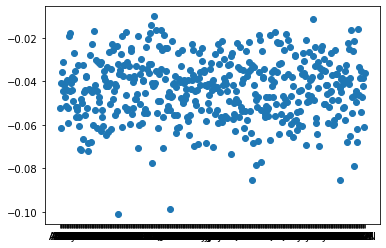

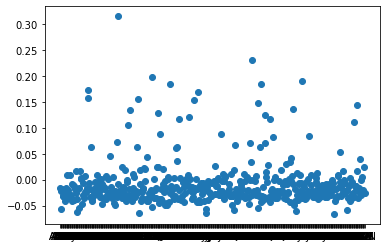

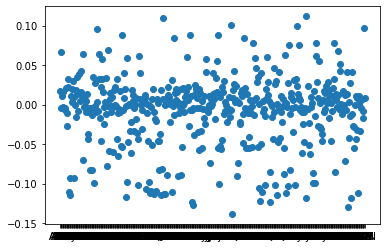

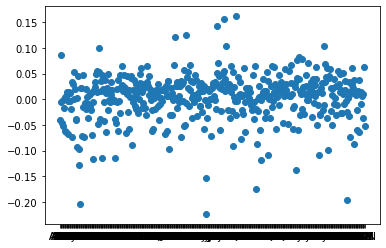

In [13]:
plt.scatter(dimReduced.index, dimReduced["P0"])
plt.show()
plt.scatter(dimReduced.index, dimReduced["P1"])
plt.show()
plt.scatter(dimReduced.index, dimReduced["P2"])
plt.show()
plt.scatter(dimReduced.index, dimReduced["P3"])
plt.show()

In [14]:
optics_model = OPTICS(min_samples = 3, cluster_method = 'dbscan', eps = 0.15) #can change or add more parameters
#nowX = preprocessing.StandardScaler().fit_transform(dimReduced) #standardize features
optics_model.fit(dimReduced) #training the model

labels_1 = cluster_optics_dbscan(reachability = optics_model.reachability_, core_distances = optics_model.core_distances_, ordering = optics_model.ordering_, eps = 0.2)
labels_2 = cluster_optics_dbscan(reachability = optics_model.reachability_, core_distances = optics_model.core_distances_, ordering = optics_model.ordering_, eps = 0.15)

space = np.arange(len(dimReduced))
reachability = optics_model.reachability_[optics_model.ordering_] #reachability dist of each point
labels = optics_model.labels_[optics_model.ordering_] #each point's cluster label
print(labels)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0  0  0
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  3  3 -1 -1 -1 -1
  4  4  4  4  4  4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

Text(0.5, 1.0, 'Clustering at 0.15 epsilon cut\nDBSCAN')

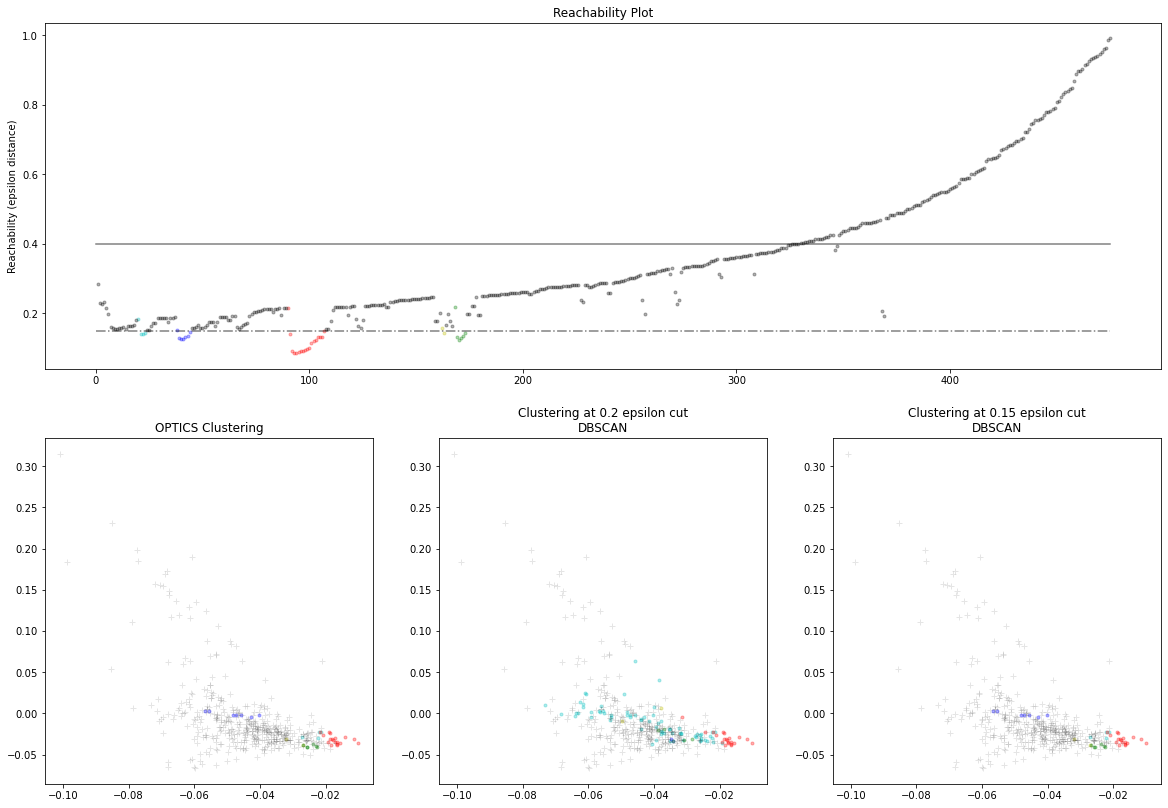

In [15]:
#Visualization
plt.figure(figsize = (20, 14))
plot_grid = gridspec.GridSpec(2, 3)
p1 = plt.subplot(plot_grid[0,:])
p2 = plt.subplot(plot_grid[1,0])
p3 = plt.subplot(plot_grid[1,1])
p4 = plt.subplot(plot_grid[1,2])

#Reachability Plot
colors = ['c.', 'b.', 'r.', 'y.', 'g.']
for currClass, color in zip(range(0, 5), colors):
    Xk = space[labels == currClass]
    Rk = reachability[labels == currClass]
    p1.plot(Xk, Rk, color, alpha = 0.3)
p1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
p1.plot(space, np.full_like(space, 0.4, dtype=float), 'k-', alpha=0.5)
p1.plot(space, np.full_like(space, 0.15, dtype=float), 'k-.', alpha=0.5)
p1.set_ylabel('Reachability (epsilon distance)')
p1.set_title('Reachability Plot')

#OPTICS Plot
colors = ['c.', 'b.', 'r.', 'y.', 'g.']
for currClass, color in zip(range(0, 5), colors):
    Xk = dimReduced[optics_model.labels_ == currClass]
    p2.plot(Xk.iloc[:, 0], Xk.iloc[:, 1], color, alpha = 0.3)
p2.plot(dimReduced.iloc[optics_model.labels_ == -1, 0], dimReduced.iloc[optics_model.labels_ == -1, 1], 'k+', alpha = 0.1)
p2.set_title('OPTICS Clustering')
    
#0.2 DBSCAN
colors = ['c.', 'b.', 'r.', 'y.', 'g.']
for currClass, color in zip(range(0, 5), colors):
    Xk = dimReduced[labels_1 == currClass]
    p3.plot(Xk.iloc[:, 0], Xk.iloc[:, 1], color, alpha=0.3, marker='.')
p3.plot(dimReduced.iloc[labels_1 == -1, 0], dimReduced.iloc[labels_1 == -1, 1], 'k+', alpha=0.1)
p3.set_title('Clustering at 0.2 epsilon cut\nDBSCAN')

#0.15 DBSCAN
colors = ['c.', 'b.', 'r.', 'y.', 'g.']
for currClass, color in zip(range(0, 5), colors):
    Xk = dimReduced[labels_2 == currClass]
    p4.plot(Xk.iloc[:, 0], Xk.iloc[:, 1], color, alpha=0.3, marker='.')
p4.plot(dimReduced.iloc[labels_2 == -1, 0], dimReduced.iloc[labels_2 == -1, 1], 'k+', alpha=0.1)
p4.set_title('Clustering at 0.15 epsilon cut\nDBSCAN')

In [16]:
#Plot & print some individual cluster data